In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

import time
import os
import copy
import pandas as pd

In [42]:
# Top level data directory
data_dir = "D:\\Users\\Anude\\Documents\\CS 497\\CAM\\celebA\\img_align_celeba"

# Number of classes in the dataset
num_classes = 2

# Batch size for training
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When True, only update reshaped layer params 
# When False, finetune the whole model, 
feature_extract = True

In [3]:
pd.__version__

'1.4.2'

In [4]:
val_df = pd.read_pickle('val.pickle')

In [6]:
train_df = pd.read_pickle('train.pickle')

In [12]:
train_df_files = train_df.drop('labels',1)

<ipython-input-12-190b724ca88e>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_df_files = train_df.drop('labels',1)


In [26]:
train_file_names = list(train_df_files.index)

In [27]:
val_file_names = list(val_df.drop('labels',1).index)

<ipython-input-27-09fe3015b657>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  val_file_names = list(val_df.drop('labels',1).index)


In [34]:
train_file_names = [os.path.join(data_dir,name) for name in train_file_names]
val_file_names = [os.path.join(data_dir,name) for name in val_file_names]

In [38]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [48]:
model_ft = models.squeezenet1_1(pretrained=True)
model_ft

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [49]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
#     model_ft = models.resnet18(pretrained=use_pretrained)
    model_ft = models.squeezenet1_1(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
#     num_ftrs = model_ft.fc.in_features
#     model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)
model_ft

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [50]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, 
#                                                    num_workers=4) for x in ['train', 'val']}

# image_datasets = {x: datasets.ImageFolder(data_dir, data_transforms[x]) for x in ['train', 'val']}
# dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, 
                                                   num_workers=4) for x in ['train', 'val']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [51]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [60]:
# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print(name)
# else:
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print(name)
    else:
        param.requires_grad = True
# print(params_to_update)
optimizer_ft = optim.AdamW(params_to_update)

In [61]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------


KeyboardInterrupt: 

In [25]:
torch.save(model_ft, "squeezenet_full.pt")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


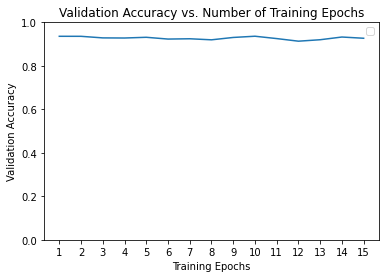

In [26]:
ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1), ohist)
plt.ylim((0, 1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()